In [1]:
import time
from style import *
from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate, displace
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt

import UD_liouv as RC
import driving_liouv as EM
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar, J_poly
from utils import ground_and_excited_states, initialise_TLS, Occupation
import pickle

In [2]:
def load_obj(name ):
    with open(name + '.pickle', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name ):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [3]:
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 33.356227807
#inv_ps_to_inv_cm = 5.309
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = J_multipolar

epsilon = 2. * ev_to_inv_cm
w0= 50e-3 * ev_to_inv_cm
Gamma = 10e-3 * ev_to_inv_cm
lifetime = 1000. #ps
Gamma_EM = (1/lifetime)*inv_ps_to_inv_cm
print(Gamma_EM)

0.033356227807


In [4]:
"""hbar_in_eV_s = 6.582119569e-16
hbar_in_eV_ps = hbar_in_eV_s*1e12
inv_ps_to_ev_2 = hbar_in_eV_ps*2*pi # factor of 2 pi as it's angular frequency
ev_to_inv_ps_2 = 1/inv_ps_to_ev_2
ev_to_inv_ps = 1/hbar_in_eV_ps
inv_ps_to_inv_cm_2 = (1/ev_to_inv_ps_2)*ev_to_inv_cm
print(inv_ps_to_inv_cm_2)"""

"hbar_in_eV_s = 6.582119569e-16\nhbar_in_eV_ps = hbar_in_eV_s*1e12\ninv_ps_to_ev_2 = hbar_in_eV_ps*2*pi # factor of 2 pi as it's angular frequency\nev_to_inv_ps_2 = 1/inv_ps_to_ev_2\nev_to_inv_ps = 1/hbar_in_eV_ps\ninv_ps_to_inv_cm_2 = (1/ev_to_inv_ps_2)*ev_to_inv_cm\nprint(inv_ps_to_inv_cm_2)"

# Figure 3.2 (a)
Emitter population dynamics from additive and non-additive theories for increasing vibrational coupling.


In [5]:
# Additive model

from qutip import sprepost, spre, spost

def lindblad(op):
    opdop = op.dag()*op
    return 2*sprepost(op, op.dag()) - (spre(opdop) + spost(opdop))
    
def L_additive(A, T_EM):
    n = Occupation(epsilon, T_EM)
    return (Gamma_EM/2.)*((n+1)*lindblad(A) + n*lindblad(A.dag()))

def build_additive_model(alpha, T_ph, T_EM, N, silent=True):
    L_model, H_model, A_EM, A_nrwa, Z, wRC, kappa, gamma = RC.RC_function_UD(sigma, epsilon, T_ph, 
                                                                           Gamma, w0, alpha, 
                                                                           N, silent=silent)
    L_model += L_additive(A_EM, T_EM)
    return H_model, L_model, A_EM

def thermal_state(T_):
    th_un = ((-epsilon*E*E.dag()/(0.695*T_)).expm())
    return ((th_un/th_un.norm())*E*E.dag()).tr()

In [6]:
# Non-additive model

def build_model(alpha, T_ph, T_EM, N, silent=True):
    print(epsilon, T_ph, Gamma, w0, alpha, N)
    L_model, H_model, A_EM, A_nrwa, Z, wRC, kappa, gamma = RC.RC_function_UD(sigma, epsilon, T_ph, 
                                                                           Gamma, w0, alpha, 
                                                                           N, silent=silent)
    #L_model += EM.L_nonsecular(H_model, A_EM, epsilon, Gamma_EM, T_EM, J_EM, silent=silent)
    print(EM.L_non_rwa(H_model, A_EM, epsilon, Gamma_EM, T_EM, J_EM, silent=silent).eigenenergies())
    L_model += EM.L_non_rwa(H_model, A_EM, epsilon, Gamma_EM, T_EM, J_EM, silent=silent)
    
    return H_model, L_model, A_EM


def calculate_dynamics(alpha, N, model):
    T_ph = 300.
    T_EM = 6000.
    H_test, L_test, A_EM = model(alpha, T_ph, T_EM, N)
    rho_0 = tensor(G*G.dag(), thermal_dm(N, Occupation(w0, T_ph)))

    e_ops=[A_EM.dag()*A_EM]

    dynamics_ = mesolve(H_test, rho_0, timelist, c_ops=[L_test], e_ops=e_ops, progress_bar=True, 
                   options=qt.Options(nsteps=8000))
    return dynamics_.expect[0]

def plot_dynamics(timelist_cm, dynamics_):
    plt.plot(timelist_cm*inv_ps_to_inv_cm/1000, dynamics_.expect[0])
    
def plot_population(timelist_cm, pop, alpha_over_ep):
    plt.plot(timelist_cm*inv_ps_to_inv_cm/1000, pop, label=r'$\alpha\epsilon^{-1}$'+'={}'.format(alpha_over_ep))

(16131.0, 300.0, 80.655, 403.27500000000003, 0.0, 3)
[-0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j  0.      +0.j  0.      +0.j
  0.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j
  0.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j
  0.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j  0.      +0.j
  0.      +0.j]
10.0%. Run time:   0.46s. Est. time left: 00:00:00:04
20.0%. Run time:   0.94s. Est. time left: 00:00:00:03
30.0%. Run time:   1.41s. Est. time left: 00:00:00:03
40.0%. Run time:   1.88s. Est. time left: 00:00:00:02
50.0%. Run time:   2.34s. Est. time left: 00:00:00:02
60.0%. Run time:   2.81s. Est. time left: 00:00:00:01
70.0%. Run time:   3.28s. Est. time left: 00:00:00:01
80.0%. Run time:   3.75s. Est. time left: 00:00:00:00
90

'for alpha_over_ep, N in zip(alpha_over_epsilon, N_vals_f2a):\n    dyn = calculate_dynamics(alpha_over_ep*epsilon, N+1, build_model)\n    data_fig2a.append(dyn)\n    plot_population(timelist, dyn, alpha_over_ep)'

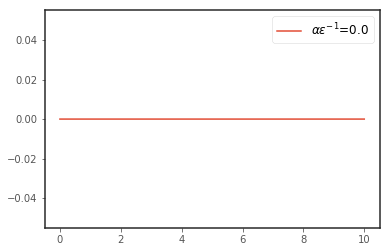

In [7]:
alpha_over_epsilon = [0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25]



timelist = np.linspace(0, 10*1e3, 3000)/inv_ps_to_inv_cm
#H_test, L_test, A_EM = build_model(alpha, T_ph, Gamma_EM, T_EM, N)

data_fig2a = []
N_vals_f2a = np.array([14, 16, 18, 21, 25])
N_vals_f2a = np.array([5, 5, 5, 5, 5, 5, 5]) # test

#dyn_a = calculate_dynamics(0., 3, build_additive_model)
#plot_population(timelist, dyn_a, 0.)
dyn = calculate_dynamics(0., 3, build_model)
plot_population(timelist, dyn, 0.)
plt.legend()

"""for alpha_over_ep, N in zip(alpha_over_epsilon, N_vals_f2a):
    dyn = calculate_dynamics(alpha_over_ep*epsilon, N+1, build_model)
    data_fig2a.append(dyn)
    plot_population(timelist, dyn, alpha_over_ep)"""

Additive and non-additive agree at zero phonon-coupling. Whatever the issue is must be to do with the inclusion of phonons, but not the phonons themselves as these agree with the exact solution. It could be to do with my implementation of the non-secular code. When N gets high enough that the highest energy states are larger than the exciton splitting, the value of the excited state population starts to decrease. Perhaps I should try the Non-RWA code to see if that is better?

In [14]:
save_obj([alpha_over_epsilon, data_fig2a], "thesis-data/dynamics_fig_2a")

# Figure 3.3 (a)

Steady-state emitter population as afunction of the electron-phonon coupling. $T_EM = 6000K$, $12000$ and $60000$.

In [30]:
def get_steadystate_population(alpha, T_ph, T_EM, N):
    H_test, L_test, A_EM = build_model(alpha, T_ph, T_EM, N)
    return (steadystate(H_test, [L_test])*A_EM.dag()*A_EM).tr()

# test

assert((get_steadystate_population(0., 300., 6000., 6) - thermal_state(6000.))<1e-12)

(16131.0, 300.0, 80.655, 403.27500000000003, 0.0, 6)
[-0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j -0.017034+0.j
 -0.017034+0.j -0.017034

(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 40)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 41)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 42)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 43)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 44)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 45)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 46)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 47)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 48)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 49)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 50)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 51)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 52)
(16131.0, 300.0, 80.655, 403.27500000000003, 12904.800000000001, 53)
(16131.0, 300.0, 80.655, 403.27500

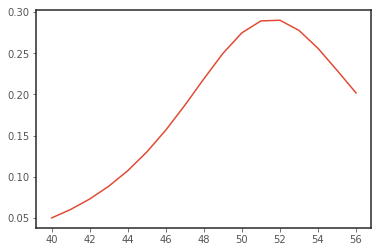

In [7]:
# Trying to get the data to converge. You need many many states.
conv_dat = []
N_vals_conv = range(40, 57)
for N_ in N_vals_conv:
    pop = get_steadystate_population(0.8*epsilon, 300., 6000., N_)
    conv_dat.append(pop)
    print(pop)
plt.plot(N_vals_conv, conv_dat)

In [31]:
thermal_state(60000.)

0.4044795542739482

[21, 26, 31, 36, 41]
(0.0, 21, 6000.0)
(3226.2000000000003, 26, 6000.0)
(6452.400000000001, 31, 6000.0)
(9678.600000000002, 36, 6000.0)
(12904.800000000001, 41, 6000.0)
6000.0
(0.0, 21, 12000.0)
(3226.2000000000003, 26, 12000.0)
(6452.400000000001, 31, 12000.0)
(9678.600000000002, 36, 12000.0)
(12904.800000000001, 41, 12000.0)
12000.0
(0.0, 21, 60000.0)
(3226.2000000000003, 26, 60000.0)
(6452.400000000001, 31, 60000.0)
(9678.600000000002, 36, 60000.0)
(12904.800000000001, 41, 60000.0)
60000.0


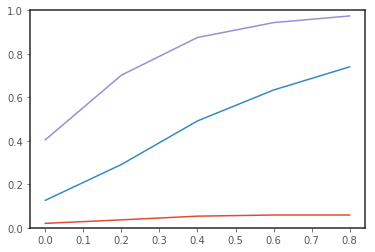

In [10]:
alpha_over_epsilon_f3 = np.linspace(0, 0.8,5)
#N_vals_f3 = [int(n)+1 for n in np.linspace(10, 23,len(alpha_over_epsilon_f3))]
N_vals_f3 = [int(n)+1 for n in np.linspace(20, 40,len(alpha_over_epsilon_f3))]
print(N_vals_f3)
data_fig3a = []
for T_EM_3a in [6e3, 12e3, 60e3]:
    row = []
    for N_3a, aoe_3a in zip(N_vals_f3, alpha_over_epsilon_f3):
        alpha_3a = aoe_3a*epsilon
        print(alpha_3a, N_3a, T_EM_3a)
        row.append(get_steadystate_population(alpha_3a, 300., T_EM_3a, N_3a))
    print(T_EM_3a)
    data_fig3a.append(row)
    plt.plot(alpha_over_epsilon_f3, row)
    plt.ylim(0,1)

In [17]:
save_obj(data_fig3a, "thesis-data/dynamics_fig_3a")

In [11]:
print(get_steadystate_population(400, 300., 12000., 15))
print(get_steadystate_population(400, 300., 12000., 16))

(16131.0, 300.0, 80.655, 403.27500000000003, 400, 15)
0.141163812393
(16131.0, 300.0, 80.655, 403.27500000000003, 400, 16)
0.141164039342


In [8]:
print(get_steadystate_population(400, 300., 12000., 15))
print(get_steadystate_population(400, 300., 12000., 16))

(16131.0, 300.0, 80.655, 403.27500000000003, 400, 15)
0.141155249205
(16131.0, 300.0, 80.655, 403.27500000000003, 400, 16)
0.141155616146


In [7]:
print(get_steadystate_population(400, 300., 12000., 15))
print(get_steadystate_population(400, 300., 12000., 16))

(16131.0, 300.0, 80.655, 403.27500000000003, 400, 15)
0.141163249874
(16131.0, 300.0, 80.655, 403.27500000000003, 400, 16)
0.14116348602
